In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearnex import patch_sklearn

patch_sklearn()

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.metrics import (accuracy_score, f1_score, precision_score,
                             recall_score)
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


### Importação e análise dos conjuntos de dados

In [2]:
SELECTED_DATABASE = "mias"

try:
    breast_cancer_df = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/first_order_features_roi_{SELECTED_DATABASE}.csv")
    # aux = pd.read_csv(f"../../outputs/mamografia/{SELECTED_DATABASE}/glcm_features_roi_{SELECTED_DATABASE}.csv")
    # breast_cancer_df = pd.concat([breast_cancer_df.drop(columns='pathology'), aux], axis=1)
except FileNotFoundError:
    raise Exception("Database not found!")

breast_cancer_df.head()

,mean,std,variance,skewness,kurtosis,central_moment,pathology
0,139.435640,126.940100,16113.7900,-0.000475,-2.999993,-384656.75,benign
1,176.327290,117.780075,13872.1455,-0.005922,-2.999914,-1354678.10,benign
2,168.688260,120.663900,14559.7770,-0.012642,-2.999497,-1199383.80,benign
3,168.688260,120.663900,14559.7770,-0.012642,-2.999497,-1199383.80,benign
4,123.088234,127.423650,16236.7870,0.001018,-2.999783,143266.00,benign


Visualizar a frequência das classes

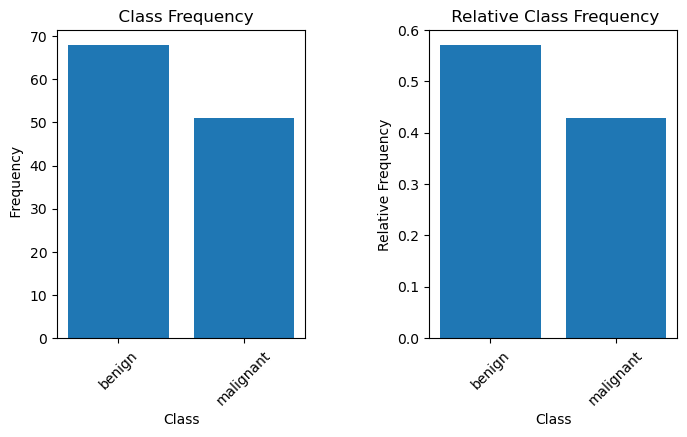

In [3]:
fig = plt.figure(figsize=(8, 4))
titles = ['', 'Relative']

for i, title in enumerate(titles, start=1):
    isRelative = True if i == 2 else False
    frequency = breast_cancer_df['pathology'].value_counts(normalize=isRelative)
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f' {title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel(f'{title} Frequency')
    plt.xticks(rotation=45)
fig.subplots_adjust(wspace=0.5)
plt.show()

### Pré-Processamento

In [4]:
# Elimina os dados com classe BENIGN_WITHOUT_CALLBACK ou NORMAL
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "benign_without_callback"]
breast_cancer_df = breast_cancer_df[breast_cancer_df["pathology"] != "normal"]

# Elimina os dados com valores nulos
breast_cancer_df.dropna(inplace=True)

# Separa em features e labels
X, y = (breast_cancer_df.drop(["pathology"], axis=1), breast_cancer_df["pathology"])

# Tratamos os rótulos categóricos
y = y.map({"benign": 0, "malignant": 1})

if SELECTED_DATABASE in ["inbreast", "mias"]:
    smote = SMOTE()
    X, y = smote.fit_resample(X, y)
elif SELECTED_DATABASE == "cmmd":
    nearmiss = NearMiss(version=1)
    X, y = nearmiss.fit_resample(X, y)

# Separa os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y)

# Padroniza os dados
for col in X_train.columns:
    scaler = MinMaxScaler()
    X_train[col] = scaler.fit_transform(X_train[col].values.reshape(-1, 1))
    X_test[col] = scaler.transform(X_test[col].values.reshape(-1, 1))

##### Visualizar Dados após pré-processamento 

In [5]:
X_train.head()

,mean,std,variance,skewness,kurtosis,central_moment
65,0.402113,1.000000,1.000000,0.923103,0.000599,0.492112
111,1.000000,0.000000,0.000000,0.835040,0.008081,0.091523
26,0.453567,0.994337,0.992990,0.917122,0.001741,0.401425
104,0.239174,0.937911,0.923983,0.936372,0.000898,0.766728
76,0.460796,0.992575,0.990812,0.913744,0.003395,0.388823


In [6]:
y_train.head()

65     1
111    1
26     1
104    1
76     0
Name: pathology, dtype: int64

##### Visualizar frequência de classe em cada parte do conjunto de dados

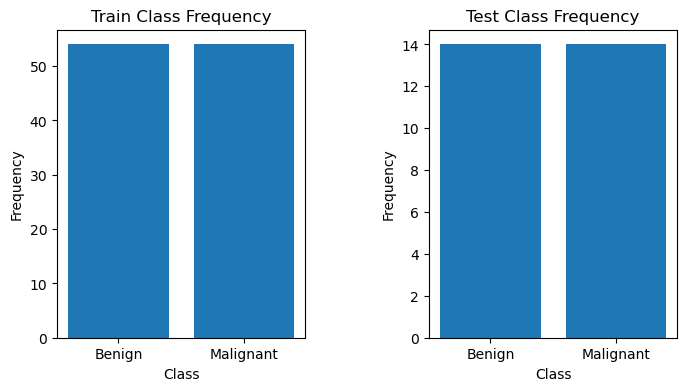

In [7]:
fig = plt.figure(figsize=(8, 4))
y_parts = [y_train, y_test]
idxs = [1, 2]
titles = ['Train', 'Test']

for i, y_part, title in zip(idxs, y_parts, titles):
    frequency = y_part.value_counts()
    frequency.index = ['Benign', 'Malignant']
    
    plt.subplot(1, 2, i)
    plt.bar(frequency.index, frequency)
    plt.title(f'{title} Class Frequency')
    plt.xlabel('Class'), plt.ylabel('Frequency')
fig.subplots_adjust(wspace=0.5)
plt.show()

### Treinamento dos modelos

##### Funções

In [8]:
# Função para criar o modelo do Keras
def create_mlp_model(shape):
    model = Sequential()
    model.add(Dense(25, input_dim=shape, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss="binary_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    return model

##### Treino dos modelos

In [9]:
# Models
random_forest_model = RandomForestClassifier(n_estimators=120, max_depth=10, criterion="gini", 
                                             min_samples_leaf=3, min_samples_split=2)
boosted_tree_model = GradientBoostingClassifier(learning_rate=0.1, max_depth=3, n_estimators=100)
mlp_model = create_mlp_model(X_train.shape[1])

threshold = 0.5
titles = ["Random Forest", "Boosted Tree", "MLP"]
models = [random_forest_model, boosted_tree_model, mlp_model]
scores = {}

for model, title in zip(models, titles):
    predict = []
    if title == "MLP":
        model.fit(X_train, y_train, epochs=100, batch_size=1, verbose=0)
        predict = model.predict(X_test)
        predict = (predict > threshold).astype(int) # Transformar as saídas em rótulos
    else:
        model.fit(X_train, y_train)
        predict = model.predict(X_test)

    scores[title] = {"accuracy_score": accuracy_score(y_test, predict) * 100}
    scores[title]["precision_score"] = precision_score(y_test, predict) * 100
    scores[title]["recall_score"] = recall_score(y_test, predict) * 100
    scores[title]["f1_score"] = f1_score(y_test, predict) * 100

1/1 [==============================] - 0s 92ms/step


### Avaliação dos modelos

In [10]:
scores_df = pd.DataFrame(scores).T
scores_df

,accuracy_score,precision_score,recall_score,f1_score
Random Forest,53.571429,52.941176,64.285714,58.064516
Boosted Tree,53.571429,53.333333,57.142857,55.172414
MLP,50.000000,50.000000,50.000000,50.000000


In [12]:
result = [[71.428571, 67.857143, 57.142857], [67.857143, 57.142857, 46.428571], [60.714286, 64.285714, 46.428571],
          [64.285714, 50.0, 50.0], [53.571429, 53.571429, 50.0]]

columns=['Random Forest', 'Boosted Tree', 'MLP']
df = pd.DataFrame(result, columns=columns)

def mean_without_extremes(df):
    new_df = pd.DataFrame(columns=df.columns)
    for col in df.columns:
        df.sort_values(by=col, inplace=True)
        df[col] = df[col].drop(df[col].index[[0, -1]])
        new_df[col] = [df[col].mean()]
    return new_df

df = mean_without_extremes(df)
df

,Random Forest,Boosted Tree,MLP
0,64.285714,58.333333,48.809524
